# Investigating CW Attack Variants Using Diversity Promoting Regularization

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import datetime
import glob
import os

import pickle

import pandas as pd

%matplotlib inline

from models import *

%load_ext autoreload
%autoreload 2

# check if CUDA is available
device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda")
else:
    print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [2]:
# load the results from file
with open('assets/results.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [3]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.manual_seed(random_seed)

In [4]:
#  torchvision.transforms.Normalize(
#    (0.1307,), (0.3081,))

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
    batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
    batch_size=batch_size_test, shuffle=True, pin_memory=True)

# targets = true labels only for when you're doing a targeted attack
# otherwise, you're going to make the inputs easier to classify to 
# do a targeted attack, targets should be some class other than
# the true label

inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

# Train

In [5]:
retrain = False
track_low_high = False

model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# check to see if we can just load a previous model
# %mkdir models
latest_model = None
m_type = model.__class__.__name__
prev_models = glob.glob('pretrained_models/mnist/*'+ m_type +'*.pth')
if prev_models:
    latest_model = max(prev_models, key=os.path.getctime)

if (retrain is False 
    and latest_model is not None 
    and m_type in latest_model):  
    print('loading model', latest_model)
    model.load_state_dict(torch.load(latest_model))  
else:
    if track_low_high:
        model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
        try:
            for epoch in range(1, n_epochs + 1):
                model.hook_lowhigh_dict('relu')
                train(model, device, train_loader, optimizer, epoch)
                model.remove_hooks()
                test(model, device, test_loader)    
        finally:
            model.remove_hooks()   
    else:
        for epoch in range(1, n_epochs + 1):
            train(model, device, train_loader, optimizer, epoch)
            acc = test(model, device, test_loader)  
    torch.save(model.state_dict(), 'pretrained_models/mnist/model_' + m_type + '_' + str(datetime.datetime.now()).replace(':','.') + '_' + str(acc) + '.pth')

loading model pretrained_models/mnist\model_ConvNet_2019-07-25 16.16.26.580052_98.82.pth


# Helper Methods

In [6]:
def atanh(x, eps=1e-2):
    """
    The inverse hyperbolic tangent function, missing in pytorch.

    :param x: a tensor or a Variable
    :param eps: used to enhance numeric stability
    :return: :math:`\\tanh^{-1}{x}`, of the same type as ``x``
    """
    x = x * (1 - eps)
    return 0.5 * torch.log((1.0 + x) / (1.0 - x))

def to_tanh_space(x, box=(-1., 1.)):
    """
    Convert a batch of tensors to tanh-space. This method complements the
    implementation of the change-of-variable trick in terms of tanh.

    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in tanh-space, of the same dimension;
             the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return atanh((x - _box_plus) / _box_mul)

def from_tanh_space(x, box=(-1., 1.)):
    """
    Convert a batch of tensors from tanh-space to oridinary image space.
    This method complements the implementation of the change-of-variable trick
    in terms of tanh.

    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in ordinary image space, of the same
             dimension; the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return torch.tanh(x) * _box_mul + _box_plus
  
def compensate_confidence(outputs, targets):
    """
    Compensate for ``self.confidence`` and returns a new weighted sum
    vector.

    :param outputs: the weighted sum right before the last layer softmax
           normalization, of dimension [B x M]
    :type outputs: np.ndarray
    :param targets: either the attack targets or the real image labels,
           depending on whether or not ``self.targeted``, of dimension [B]
    :type targets: np.ndarray
    :return: the compensated weighted sum of dimension [B x M]
    :rtype: np.ndarray
    """
    outputs_comp = outputs.clone()
    rng = torch.range(start=0, end=targets.shape[0]-1, dtype=torch.long, device=device)
    # targets = targets.int()
    if targeted:
        # for each image $i$:
        # if targeted, `outputs[i, target_onehot]` should be larger than
        # `max(outputs[i, ~target_onehot])` by `self.confidence`
        outputs_comp[rng, targets] -= confidence
    else:
        # for each image $i$:
        # if not targeted, `max(outputs[i, ~target_onehot]` should be larger
        # than `outputs[i, target_onehot]` (the ground truth image labels)
        # by `self.confidence`
        outputs_comp[rng, targets] += confidence
    return outputs_comp
  
def attack_successful(prediction, target):
    """
    See whether the underlying attack is successful.
    """
    if targeted:
        return prediction == target
    else:
        return prediction != target
      
def norm_divergence(data, model, layer, neuron=None, regularizer_weight=None):
    """
    returns the kld between the activations of the specified layer and a uniform pdf
    """
    # extract layer activations as numpy array
    layer_activations = torch.squeeze(model.extract_outputs(data=data, layer=layer))
    
    # normalize over summation (to get a probability density)
    out_norm = torch.sum(layer_activations, 0)
    out_norm = out_norm / torch.sum(out_norm) + 1e-6 # F.softmax(out_norm, 1)

    # create uniform tensor
    uniform_tensor = torch.ones(out_norm.shape).to(device)

    # normalize over summation (to get a probability density)
    uni_norm = uniform_tensor / torch.sum(uniform_tensor)
    
    # measure divergence between normalized layer activations and uniform distribution
    divergence = F.kl_div(input=out_norm.log(), target=uni_norm, reduction='sum')
    
    # default regularizer if not provided
    if regularizer_weight is None:
        regularizer_weight = 0.005 
    
    return regularizer_weight * divergence

def eval_performance(model, originals, adversaries):
    pert_output = model(adversaries)
    orig_output = model(originals)

    pert_pred = torch.argmax(pert_output, dim=1)
    orig_pred = torch.argmax(orig_output, dim=1)

    pert_correct = pert_pred.eq(targets.data).sum()
    orig_correct = orig_pred.eq(targets.data).sum()

    pert_acc = 100. * pert_correct / len(targets)
    orig_acc = 100. * orig_correct / len(targets)

    print('Perturbed Accuracy: {}/{} ({:.0f}%)'.format(pert_correct, len(targets), pert_acc))
    print('Original Accuracy: {}/{} ({:.0f}%)'.format(orig_correct, len(targets), orig_acc))
    
    return pert_acc, orig_acc

def sample_images(originals, adversaries, num_samples = 5):
    orig_inputs = originals.cpu().detach().numpy()
    adv_examples = adversaries.cpu().detach().numpy()
    pert_output = model(adversaries)
    orig_output = model(originals)
    pert_pred = torch.argmax(pert_output, dim=1)
    orig_pred = torch.argmax(orig_output, dim=1)
    plt.figure(figsize=(15,8))
    for i in range(1, num_samples+1):
        plt.subplot(2, num_samples, i)
        plt.imshow(np.squeeze(orig_inputs[i]), cmap='gray')  
        plt.title('true: {}'.format(targets[i].item()))
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2, num_samples, num_samples+i)
        plt.imshow(np.squeeze(adv_examples[i]), cmap='gray')
        plt.title('adv_pred: {} - orig_pred: {}'.format(pert_pred[i].item(), orig_pred[i].item()))
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()

# Attack Time

| Version | Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - | - |
|  Baseline CW | CW |  True | L2 |  L2 |
|  Diversity v1 | CW |  True | Batch Divergence | Instance Divergence |
|  Diversity v2 | CW |  False | Batch Divergence | Instance Divergence |
|  Diversity v3 | Cross Entropy |  False | Batch Divergence | Instance Divergence |
|  Diversity v4 | CW |  True | Batch Divergence | L2 |

In [7]:
targeted=False
confidence=0.0
c_range=(1e-3, 1e10)
search_steps=10
max_steps=1000
abort_early=True
optimizer_lr=5e-4

mean = (0.1307,) # the mean used in inputs normalization
std = (0.3081,) # the standard deviation used in inputs normalization
box = (min((0 - m) / s for m, s in zip(mean, std)),
       max((1 - m) / s for m, s in zip(mean, std)))

log_frequency = 100

## Baseline CW

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  True | L2 | L2 |

In [8]:
def cw_l2_attack(model, inputs, targets, targeted=False, confidence=0.0,
                 c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                 abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                 init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # `lower_bounds`, `upper_bounds` and `scale_consts` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds < scale_consts <= upper_bounds
    lower_bounds = torch.tensor(np.zeros(batch_size), dtype=torch.float, device=device)
    upper_bounds = torch.tensor(np.ones(batch_size) * c_range[1], dtype=torch.float, device=device)
    scale_consts = torch.tensor(np.ones(batch_size) * c_range[0], dtype=torch.float, device=device)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_l2`          : the least L2 norms
    # - `o_best_l2_ppred`    : the perturbed predictions made by the adversarial perturbations with the least L2 norms
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_l2_ppred`
    o_best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    for const_step in range(search_steps):

        print('Step', const_step, scale_consts)

        # the minimum L2 norms of perturbations found during optimization
        best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

        # the perturbed predictions made by the adversarial perturbations with the least L2 norms
        best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

        # previous (summed) batch loss, to be used in early stopping policy
        prev_batch_loss = torch.tensor(np.inf, device=device)
        ae_tol = torch.tensor(1e-4, device=device)

        # optimization steps
        for optim_step in range(max_steps):

            adversaries = from_tanh_space(inputs_tanh + pert_tanh)
            pert_outputs = model(adversaries)

            # Calculate L2 norm between adversaries and original inputs
            pert_norms = torch.pow(adversaries - inputs, exponent=2)
            pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)

            target_activ = torch.sum(targets_oh * pert_outputs, 1)
            maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

            if targeted:           
                # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
                f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
            else:
                # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
                f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)

            # the total loss of current batch, should be of dimension [1]
            l2_loss = torch.sum(pert_norms)
            cw_loss = torch.sum(scale_consts * f)
            batch_loss = cw_loss + l2_loss # torch.sum(pert_norms + scale_consts * f)

            # Do optimization for one step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            # "returns" batch_loss, pert_norms, pert_outputs, adversaries

            if optim_step % log_frequency == 0: 
                print('batch [{}] loss: {} cw_loss: {} l2_loss: {}'.format(optim_step, batch_loss, cw_loss, l2_loss))
                # print('pert_norms', pert_norms.size(), pert_norms)
                # print('target_activ', target_activ.size(), target_activ)
                # print('maxother_activ', maxother_activ.size(), maxother_activ)

            if abort_early and not optim_step % (max_steps // 10):   
                if batch_loss > prev_batch_loss * (1 - ae_tol):
                    break
                prev_batch_loss = batch_loss

            # update best attack found during optimization
            pert_predictions = torch.argmax(pert_outputs, dim=1)
            comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
            for i in range(batch_size):
                l2 = pert_norms[i]
                cppred = comp_pert_predictions[i]
                ppred = pert_predictions[i]
                tlabel = targets[i]
                ax = adversaries[i]
                if attack_successful(cppred, tlabel):
                    assert cppred == ppred
                    if l2 < best_l2[i]:
                        best_l2[i] = l2
                        best_l2_ppred[i] = ppred
                    if l2 < o_best_l2[i]:
                        o_best_l2[i] = l2
                        o_best_l2_ppred[i] = ppred
                        o_best_adversaries[i] = ax

        # binary search of `scale_const`
        for i in range(batch_size):
            tlabel = targets[i]
            if best_l2_ppred[i] != -1:
                # successful: attempt to lower `scale_const` by halving it
                if scale_consts[i] < upper_bounds[i]:
                    upper_bounds[i] = scale_consts[i]
                # `upper_bounds[i] == c_range[1]` implies no solution
                # found, i.e. upper_bounds[i] has never been updated by
                # scale_consts[i] until `scale_consts[i] > 0.1 * c_range[1]`
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
            else:
                # failure: multiply `scale_const` by ten if no solution
                # found; otherwise do binary search
                if scale_consts[i] > lower_bounds[i]:
                    lower_bounds[i] = scale_consts[i]
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
                else:
                    scale_consts[i] *= 10
                    
    return o_best_adversaries

In [9]:
cw_advs = cw_l2_attack(model, inputs, targets, targeted=False, confidence=0.0,
                       c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                       abort_early=True, box=box, optimizer_lr=5e-4, 
                       init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs)
sample_images(inputs, cw_advs)

## Diversity Attack v1

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  True | Batch Divergence | Instance Divergence |

In [9]:
def cw_div1_attack(model, layer, regularizer_weight, inputs, targets, targeted=False, 
                   confidence=0.0, c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                   abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                   init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # `lower_bounds`, `upper_bounds` and `scale_consts` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds < scale_consts <= upper_bounds
    lower_bounds = torch.tensor(np.zeros(batch_size), dtype=torch.float, device=device)
    upper_bounds = torch.tensor(np.ones(batch_size) * c_range[1], dtype=torch.float, device=device)
    scale_consts = torch.tensor(np.ones(batch_size) * c_range[0], dtype=torch.float, device=device)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_div`         : the least divergences
    # - `o_best_div_ppred`   : the perturbed predictions made by the adversarial perturbations with the least divergences
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_div_ppred`
    o_best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    for const_step in range(search_steps):

        print('Step', const_step)

        # the minimum divergences of perturbations found during optimization
        best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

        # the perturbed predictions made by the adversarial perturbations with the least divergences
        best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

        # previous (summed) batch loss, to be used in early stopping policy
        prev_batch_loss = torch.tensor(np.inf, device=device)
        ae_tol = torch.tensor(1e-4, device=device)

        # optimization steps
        for optim_step in range(max_steps):

            adversaries = from_tanh_space(inputs_tanh + pert_tanh)
            pert_outputs = model(adversaries)
            
            # Calculate L2 norm between adversaries and original inputs
            pert_norms = torch.pow(adversaries - inputs, exponent=2)
            pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)

            # calculate kl divergence for each input to use for adversary selection
            divs = []
            for i in range(batch_size):
                divs.append(norm_divergence(data=adversaries[i].unsqueeze(0), model=model, layer=layer, regularizer_weight=regularizer_weight)) 
            div_norms = torch.tensor(torch.stack(divs), device=device)
            
            # calculate kl divergence for batch to use in loss function
            div_reg = norm_divergence(data=adversaries, model=model, layer=layer, regularizer_weight=regularizer_weight)

            target_activ = torch.sum(targets_oh * pert_outputs, 1)
            maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

            if targeted:           
                # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
                f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
            else:
                # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
                f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)
 
            batch_loss = torch.sum(scale_consts * f + pert_norms) + div_reg

            # Do optimization for one step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            # "returns" batch_loss, pert_norms, pert_outputs, adversaries

            if optim_step % log_frequency == 0: 
                print('batch [{}] loss: {}'.format(optim_step, batch_loss))

            if abort_early and not optim_step % (max_steps // 10):   
                if batch_loss > prev_batch_loss * (1 - ae_tol):
                    break
                if batch_loss == 0:
                    break
                prev_batch_loss = batch_loss

            # update best attack found during optimization
            pert_predictions = torch.argmax(pert_outputs, dim=1)
            comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
            for i in range(batch_size):
                div = div_norms[i]
                cppred = comp_pert_predictions[i]
                ppred = pert_predictions[i]
                tlabel = targets[i]
                ax = adversaries[i]
                if attack_successful(cppred, tlabel):
                    assert cppred == ppred
                    if div < best_div[i]:
                        best_div[i] = div
                        best_div_ppred[i] = ppred
                    if div < o_best_div[i]:
                        o_best_div[i] = div
                        o_best_div_ppred[i] = ppred
                        o_best_adversaries[i] = ax

        # binary search of `scale_const`
        for i in range(batch_size):
            tlabel = targets[i]
            if best_div_ppred[i] != -1:
                # successful: attempt to lower `scale_const` by halving it
                if scale_consts[i] < upper_bounds[i]:
                    upper_bounds[i] = scale_consts[i]
                # `upper_bounds[i] == c_range[1]` implies no solution
                # found, i.e. upper_bounds[i] has never been updated by
                # scale_consts[i] until `scale_consts[i] > 0.1 * c_range[1]`
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
            else:
                # failure: multiply `scale_const` by ten if no solution
                # found; otherwise do binary search
                if scale_consts[i] > lower_bounds[i]:
                    lower_bounds[i] = scale_consts[i]
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
                else:
                    scale_consts[i] *= 10
                    
    return o_best_adversaries, div_norms

Step 0
batch [0] loss: 0.8855794072151184
batch [100] loss: 0.5745366215705872
batch [200] loss: 0.2935900092124939
batch [300] loss: 0.10789364576339722
batch [400] loss: 0.039856232702732086
batch [500] loss: 0.011844517663121223
batch [600] loss: 0.006393809802830219
batch [700] loss: 0.003487696871161461
batch [800] loss: 0.0010391379473730922
batch [900] loss: -9.536738616588991e-07
Step 1
batch [0] loss: -9.536738616588991e-07
Step 2
batch [0] loss: -9.536738616588991e-07
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 97/100 (97%)


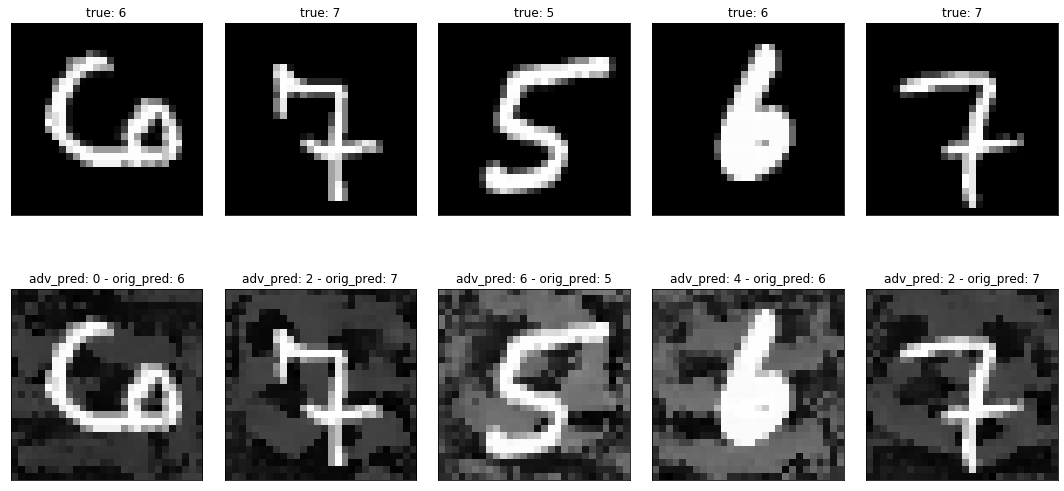

In [10]:
cw_advs_div1, div_norms1 = cw_div1_attack(model, 'relu3', 1, inputs, targets, targeted=False, confidence=0.0,
                                          c_range=(1e-3, 1e10), search_steps=3, max_steps=1000, 
                                          abort_early=True, box=box, optimizer_lr=5e-4, 
                                          init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div1)
sample_images(inputs, cw_advs_div1)

## Diversity Attack v2

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  False | Batch Divergence | Instance Divergence |

In [8]:
def cw_div2_attack(model, layer, regularizer_weight, inputs, targets, targeted=False, 
                   confidence=0.0, c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                   abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                   init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_div`         : the least divergences
    # - `o_best_div_ppred`   : the perturbed predictions made by the adversarial perturbations with the least divergences
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_div_ppred`
    o_best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    # the minimum divergences of perturbations found during optimization
    best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

    # the perturbed predictions made by the adversarial perturbations with the least divergences
    best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

    # previous (summed) batch loss, to be used in early stopping policy
    prev_batch_loss = torch.tensor(np.inf, device=device)
    ae_tol = torch.tensor(1e-4, device=device)

    # optimization steps
    for optim_step in range(max_steps):

        adversaries = from_tanh_space(inputs_tanh + pert_tanh)
        pert_outputs = model(adversaries)

        # Calculate L2 norm between adversaries and original inputs
        pert_norms = torch.pow(adversaries - inputs, exponent=2)
        pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)
        
        # calculate kl divergence for each input to use for adversary selection
        divs = []
        for i in range(batch_size):
            divs.append(norm_divergence(data=adversaries[i].unsqueeze(0), model=model, layer=layer, regularizer_weight=regularizer_weight)) 
        div_norms = torch.tensor(torch.stack(divs), device=device)

        # calculate kl divergence for batch to use in loss function
        div_reg = norm_divergence(data=adversaries, model=model, layer=layer, regularizer_weight=regularizer_weight)

        target_activ = torch.sum(targets_oh * pert_outputs, 1)
        maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

        if targeted:           
            # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
            f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
        else:
            # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
            f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)

        # the total loss of current batch, should be of dimension [1]
        l2_loss = torch.sum(pert_norms)
        cw_loss = torch.sum(f)
        batch_loss = cw_loss + l2_loss + div_reg

        # Do optimization for one step
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # "returns" batch_loss, pert_norms, pert_outputs, adversaries

        if optim_step % log_frequency == 0: 
            print('batch [{}] loss: {}'.format(optim_step, batch_loss))

        if abort_early and not optim_step % (max_steps // 10):   
            if batch_loss > prev_batch_loss * (1 - ae_tol):
                break
            if batch_loss == 0:
                break
            prev_batch_loss = batch_loss

        # update best attack found during optimization
        pert_predictions = torch.argmax(pert_outputs, dim=1)
        comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
        for i in range(batch_size):
            div = div_norms[i]
            cppred = comp_pert_predictions[i]
            ppred = pert_predictions[i]
            tlabel = targets[i]
            ax = adversaries[i]
            if attack_successful(cppred, tlabel):
                assert cppred == ppred
                if div < best_div[i]:
                    best_div[i] = div
                    best_div_ppred[i] = ppred
                if div < o_best_div[i]:
                    o_best_div[i] = div
                    o_best_div_ppred[i] = ppred
                    o_best_adversaries[i] = ax
                    
    return o_best_adversaries, div_norms

batch [0] loss: 885.580322265625
batch [100] loss: 574.2347412109375
batch [200] loss: 293.3100891113281
batch [300] loss: 107.80253601074219
batch [400] loss: 39.769771575927734
batch [500] loss: 11.803268432617188
batch [600] loss: 6.367772102355957
batch [700] loss: 3.3678932189941406
batch [800] loss: 1.0025367736816406
batch [900] loss: -9.536738616588991e-07
Perturbed Accuracy: 0/100 (0%)
Original Accuracy: 97/100 (97%)


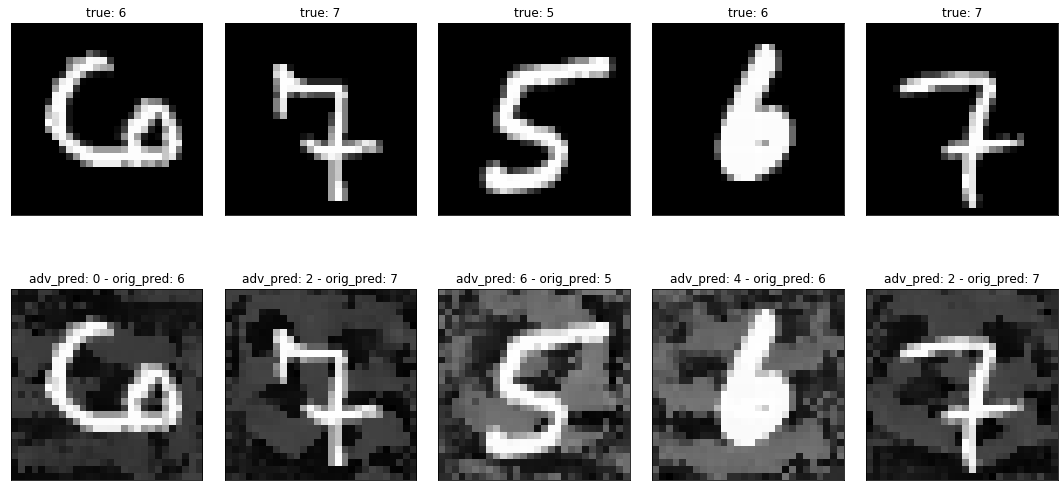

In [9]:
cw_advs_div2, div_norms2 = cw_div2_attack(model, 'relu3', 1, inputs, targets, targeted=False, confidence=0.0,
                                          c_range=(1e-3, 1e10), search_steps=1, max_steps=1000, 
                                          abort_early=True, box=box, optimizer_lr=5e-4, 
                                          init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div2)
sample_images(inputs, cw_advs_div2)

## Diversity Attack v3

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
| Cross Entropy |  False | Batch Divergence | Instance Divergence |

In [12]:
def cw_div3_attack(model, layer, regularizer_weight, inputs, targets, targeted=False, 
                   confidence=0.0, c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                   abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                   init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_div`         : the least divergences
    # - `o_best_div_ppred`   : the perturbed predictions made by the adversarial perturbations with the least divergences
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_div_ppred`
    o_best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    # the minimum divergences of perturbations found during optimization
    best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

    # the perturbed predictions made by the adversarial perturbations with the least divergences
    best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

    # previous (summed) batch loss, to be used in early stopping policy
    prev_batch_loss = torch.tensor(np.inf, device=device)
    ae_tol = torch.tensor(1e-4, device=device)

    # optimization steps
    for optim_step in range(max_steps):

        adversaries = from_tanh_space(inputs_tanh + pert_tanh)
        pert_outputs = model(adversaries)

        # Calculate L2 norm between adversaries and original inputs
        pert_norms = torch.pow(adversaries - inputs, exponent=2)
        pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)
        
        # calculate kl divergence for each input to use for adversary selection
        divs = []
        for i in range(batch_size):
            divs.append(norm_divergence(data=adversaries[i].unsqueeze(0), model=model, layer=layer, regularizer_weight=regularizer_weight)) 
        div_norms = torch.tensor(torch.stack(divs), device=device)

        # calculate kl divergence for batch to use in loss function
        div_reg = norm_divergence(data=adversaries, model=model, layer=layer, regularizer_weight=regularizer_weight)

        loss = -1. * nn.CrossEntropyLoss()(pert_outputs, targets)

        # the total loss of current batch, should be of dimension [1]
        l2_loss = torch.sum(pert_norms)
        batch_loss = torch.sum(loss) + l2_loss + div_reg

        # Do optimization for one step
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # "returns" batch_loss, pert_norms, pert_outputs, adversaries

        if optim_step % log_frequency == 0: 
            print('batch [{}] loss: {}'.format(optim_step, batch_loss))

        if abort_early and not optim_step % (max_steps // 10):   
            if batch_loss > prev_batch_loss * (1 - ae_tol):
                break
            if batch_loss == 0:
                break
            prev_batch_loss = batch_loss

        # update best attack found during optimization
        pert_predictions = torch.argmax(pert_outputs, dim=1)
        comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
        for i in range(batch_size):
            div = div_norms[i]
            cppred = comp_pert_predictions[i]
            ppred = pert_predictions[i]
            tlabel = targets[i]
            ax = adversaries[i]
            if attack_successful(cppred, tlabel):    
                assert cppred == ppred
                if div < best_div[i]:
                    best_div[i] = div
                    best_div_ppred[i] = ppred
                if div < o_best_div[i]:
                    o_best_div[i] = div
                    o_best_div_ppred[i] = ppred
                    o_best_adversaries[i] = ax
                    
    return o_best_adversaries, div_norms

In [12]:
cw_advs_div3, div_norms3 = cw_div3_attack(model, 'relu3', 1, inputs, targets, targeted=False, confidence=0.0,
                                          c_range=(1e-3, 1e10), search_steps=1, max_steps=1000, 
                                          abort_early=True, box=box, optimizer_lr=5e-4, 
                                          init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div3)
sample_images(inputs, cw_advs_div3)

## Diversity Attack v4

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
| CW |  True | Batch Divergence | L2 |

In [13]:
def cw_div4_attack(model, layer, regularizer_weight, inputs, targets, targeted=False, 
                   confidence=0.0, c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                   abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                   init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # `lower_bounds`, `upper_bounds` and `scale_consts` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds < scale_consts <= upper_bounds
    lower_bounds = torch.tensor(np.zeros(batch_size), dtype=torch.float, device=device)
    upper_bounds = torch.tensor(np.ones(batch_size) * c_range[1], dtype=torch.float, device=device)
    scale_consts = torch.tensor(np.ones(batch_size) * c_range[0], dtype=torch.float, device=device)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_l2`          : the least L2 norms
    # - `o_best_l2_ppred`    : the perturbed predictions made by the adversarial perturbations with the least L2 norms
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_l2_ppred`
    o_best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    for const_step in range(search_steps):

        print('Step', const_step)

        # the minimum L2 norms of perturbations found during optimization
        best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

        # the perturbed predictions made by the adversarial perturbations with the least L2 norms
        best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

        # previous (summed) batch loss, to be used in early stopping policy
        prev_batch_loss = torch.tensor(np.inf, device=device)
        ae_tol = torch.tensor(1e-4, device=device) # abort early tolerance

        # optimization steps
        for optim_step in range(max_steps):

            adversaries = from_tanh_space(inputs_tanh + pert_tanh)
            pert_outputs = model(adversaries)

            # Calculate L2 norm between adversaries and original inputs to use for adversary selection
            pert_norms = torch.pow(adversaries - inputs, exponent=2)
            pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)
            
            # calculate kl divergence for batch to use in loss function
            div_reg = norm_divergence(data=adversaries, model=model, layer=layer, regularizer_weight=regularizer_weight)

            target_activ = torch.sum(targets_oh * pert_outputs, 1)
            maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

            if targeted:           
                # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
                f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
            else:
                # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
                f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)

            # the total loss of current batch, should be of dimension [1]
            l2_loss = torch.sum(pert_norms)
            cw_loss = torch.sum(scale_consts * f)
            batch_loss = cw_loss + l2_loss + div_reg

            # Do optimization for one step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            # "returns" batch_loss, pert_norms, pert_outputs, adversaries

            if optim_step % log_frequency == 0: 
                print('batch [{}] loss: {}'.format(optim_step, batch_loss))

            if abort_early and not optim_step % (max_steps // 10):
                if batch_loss > prev_batch_loss * (1 - ae_tol):
                    break
                if batch_loss == 0:
                    break
                prev_batch_loss = batch_loss

            # update best attack found during optimization
            pert_predictions = torch.argmax(pert_outputs, dim=1)
            comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
            for i in range(batch_size):
                l2 = pert_norms[i]
                cppred = comp_pert_predictions[i]
                ppred = pert_predictions[i]
                tlabel = targets[i]
                ax = adversaries[i]
                if attack_successful(cppred, tlabel):
                    assert cppred == ppred
                    if l2 < best_l2[i]:
                        best_l2[i] = l2
                        best_l2_ppred[i] = ppred
                    if l2 < o_best_l2[i]:
                        o_best_l2[i] = l2
                        o_best_l2_ppred[i] = ppred
                        o_best_adversaries[i] = ax

        # binary search of `scale_const`
        for i in range(batch_size):
            tlabel = targets[i]
            if best_l2_ppred[i] != -1:
                # successful: attempt to lower `scale_const` by halving it
                if scale_consts[i] < upper_bounds[i]:
                    upper_bounds[i] = scale_consts[i]
                # `upper_bounds[i] == c_range[1]` implies no solution
                # found, i.e. upper_bounds[i] has never been updated by
                # scale_consts[i] until `scale_consts[i] > 0.1 * c_range[1]`
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
            else:
                # failure: multiply `scale_const` by ten if no solution
                # found; otherwise do binary search
                if scale_consts[i] > lower_bounds[i]:
                    lower_bounds[i] = scale_consts[i]
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
                else:
                    scale_consts[i] *= 10
                    
    return o_best_adversaries, pert_norms

In [ ]:
cw_advs_div4, l2_norms4 = cw_div4_attack(model, 'relu3', 1, inputs, targets, targeted=False, confidence=0.,
                                         c_range=(1e-3, 1e10), search_steps=1, max_steps=1000, 
                                         abort_early=True, box=box, optimizer_lr=5e-4, 
                                         init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div4)
sample_images(inputs, cw_advs_div4)

Step 0
batch [0] loss: 13.665948867797852 cw_loss: 0.8855803608894348 L2_loss: 0.872971773147583 div_reg: 11.90739631652832
batch [100] loss: 12.52118968963623 cw_loss: 0.8866482973098755 L2_loss: 0.46083131432533264 div_reg: 11.173709869384766
batch [200] loss: 12.39682388305664 cw_loss: 0.8876481056213379 L2_loss: 0.33473479747772217 div_reg: 11.17444133758545
batch [300] loss: 12.319329261779785 cw_loss: 0.8883450031280518 L2_loss: 0.25619450211524963 div_reg: 11.174789428710938
batch [400] loss: 12.266785621643066 cw_loss: 0.8888955116271973 L2_loss: 0.20274680852890015 div_reg: 11.175143241882324
batch [500] loss: 12.229269981384277 cw_loss: 0.8893411159515381 L2_loss: 0.1646054983139038 div_reg: 11.175323486328125
batch [600] loss: 12.201727867126465 cw_loss: 0.8897002935409546 L2_loss: 0.13613459467887878 div_reg: 11.17589282989502
batch [700] loss: 12.182663917541504 cw_loss: 0.8900155425071716 L2_loss: 0.11634622514247894 div_reg: 11.176301956176758
batch [800] loss: 12.167934

# Evaluation

timestamp 2019-08-05 17.39.14.923147 attack cw_div4_attack layer:  relu1-1 regularization_weight:  10 confidence:  40
Step 0
batch [0] loss: 124.82777404785156 cw_loss: 4.880842208862305 L2_loss: 0.872971773147583 div_reg: 119.07395935058594
batch [100] loss: 116.20169067382812 cw_loss: 4.880100250244141 L2_loss: 0.8589286804199219 div_reg: 110.46266174316406
batch [200] loss: 116.08003997802734 cw_loss: 4.881079196929932 L2_loss: 0.7365540266036987 div_reg: 110.46240997314453
batch [300] loss: 116.00410461425781 cw_loss: 4.881726264953613 L2_loss: 0.6586472988128662 div_reg: 110.46372985839844
batch [400] loss: 115.95046997070312 cw_loss: 4.882249355316162 L2_loss: 0.6031482219696045 div_reg: 110.46507263183594
batch [500] loss: 115.91517639160156 cw_loss: 4.882678031921387 L2_loss: 0.5662947297096252 div_reg: 110.46620178222656
batch [600] loss: 115.88787841796875 cw_loss: 4.883026123046875 L2_loss: 0.5387355089187622 div_reg: 110.46611785888672
batch [700] loss: 115.86768341064453 c

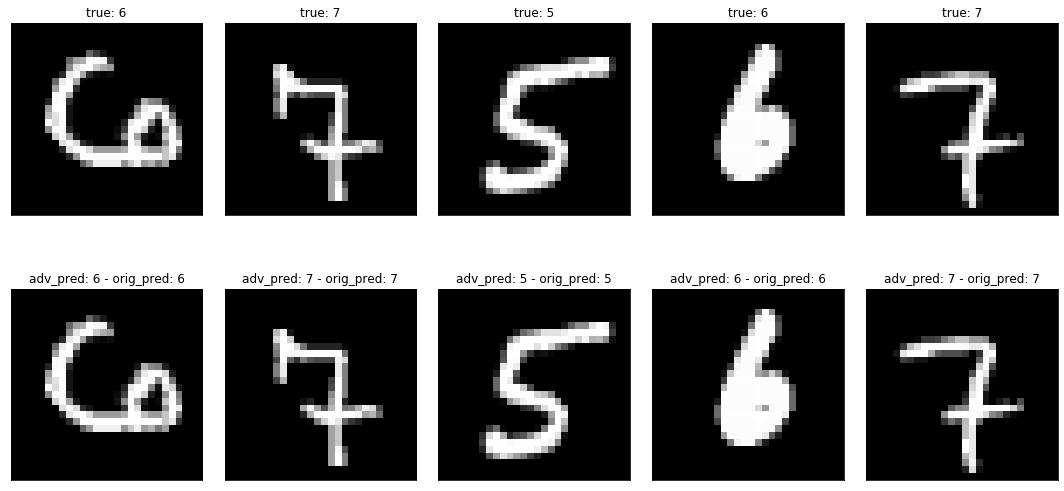

timestamp 2019-08-05 17.40.34.932214 attack cw_div4_attack layer:  relu1-1 regularization_weight:  10 confidence:  20
Step 0
batch [0] loss: 122.82777404785156 cw_loss: 2.880842447280884 L2_loss: 0.872971773147583 div_reg: 119.07395935058594
batch [100] loss: 114.20146942138672 cw_loss: 2.8800973892211914 L2_loss: 0.8586471080780029 div_reg: 110.46272277832031


KeyboardInterrupt: 

In [21]:
results = []

all_layers = list(dict(model.named_children()))
target_layers = [layer for layer in all_layers if 'relu' in layer]
attack_versions = [cw_div1_attack, cw_div2_attack, cw_div3_attack, cw_div4_attack]

for attack in attack_versions:
    for l in target_layers:
        for rw in [0, 0.001, 0.01, 1, 10, 100]:
            timestamp = str(datetime.datetime.now()).replace(':','.')
            print('timestamp', timestamp, 'attack', attack.__name__, 'layer: ', l, 'regularization_weight: ', rw)
            cw_advs_divs, divergences = attack(model, l, rw, inputs, targets, targeted=False, confidence=0.0,
                                               c_range=(1e-3, 1e10), search_steps=3, max_steps=1000, 
                                               abort_early=True, box=box, optimizer_lr=5e-4, 
                                               init_rand=False, log_frequency=100)

            pert_acc, orig_acc = eval_performance(model, inputs, cw_advs_divs)
            sample_images(inputs, cw_advs_divs)
            
            pert_acc = pert_acc.item() / 100.
            orig_acc = orig_acc.item() / 100.

            out = {'timestamp': timestamp, 'attack': attack.__name__, 'layer': l, 'regularization_weight': rw, 'adversaries': cw_advs_divs, 'divergences':divergences, 'pert_acc':pert_acc, 'orig_acc': orig_acc}
            results.append(out)

In [15]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc']]

,attack,layer,regularization_weight,orig_acc,pert_acc
0,cw_div1_attack,relu1,0.000,0.98,0.00
1,cw_div1_attack,relu1,0.001,0.98,0.00
2,cw_div1_attack,relu1,0.010,0.98,0.00
3,cw_div1_attack,relu1,1.000,0.98,0.00
4,cw_div1_attack,relu1,10.000,0.98,0.01
5,cw_div1_attack,relu1,100.000,0.98,0.01
6,cw_div1_attack,relu2,0.000,0.98,0.00
7,cw_div1_attack,relu2,0.001,0.98,0.00
8,cw_div1_attack,relu2,0.010,0.98,0.00
9,cw_div1_attack,relu2,1.000,0.98,0.00


In [16]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results.pickle", "wb" ))

In [13]:
# load the results from file
with open('assets/results.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [14]:
len(results)

73

# Coverage Criteria

## Neuron Coverage (DeepXplore)

In [21]:
def get_layer_output_sizes(model, data):   
    output_sizes = {}
    hooks = []  
    layers = list(dict(model.named_children()))   
    def hook(module, input, output):
        module_idx = len(output_sizes)
        m_key = layers[module_idx]
        output_sizes[m_key] = list(output.size()[1:])      
    for name, module in model.named_children():
        if (not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)):
            hooks.append(module.register_forward_hook(hook))
    try:
        out = model(data[:1])  
    finally:
        for h in hooks:
            h.remove()       
    return output_sizes

def get_init_dict(model, data, init_value=False): 
    output_sizes = get_layer_output_sizes(model, data)       
    model_layer_dict = {}  
    for layer, output_size in output_sizes.items():
        for index in range(np.prod(output_size)):
            # since we only care about post-activation outputs
            if 'relu' in layer.lower():
                model_layer_dict[(layer, index)] = init_value               
    return model_layer_dict

def neurons_covered(model_layer_dict):
    covered_neurons = len([v for v in model_layer_dict.values() if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)

def scale(out, rmax=1, rmin=0):
    output_std = (out - out.min()) / (out.max() - out.min())
    output_scaled = output_std * (rmax - rmin) + rmin
    return output_scaled

def update_coverage(model, data, model_layer_dict, threshold=0.):   
    layers = list(set([x[0] for x in list(model_layer_dict.keys())]))    
    for layer in layers:       
        outputs = torch.squeeze(model.extract_outputs(data, layer))
        scaled_outputs = scale(outputs)            
        for i, out in enumerate(scaled_outputs.view(-1)):
            if out > threshold:
                model_layer_dict[(layer, i)] = True
                
def eval_nc(model, data, threshold=0.):
    model_layer_dict = get_init_dict(model, data, False)
    update_coverage(model, data, model_layer_dict, threshold=0.)
    _, _, nc = neurons_covered(model_layer_dict)
    return nc

In [22]:
# test baseline (unperturbed) inputs
eval_nc(model, inputs, threshold=0.)

0.6015768725361367

In [25]:
for i in range(len(results)):
    a = results[i]['attack'] 
    l = results[i]['layer']
    rw = results[i]['regularization_weight']
    nc = eval_nc(model, results[i]['adversaries'], threshold=0.)
    results[i]['neuron_coverage'] = nc
    print(i, a, l, rw, nc) 

0 cw_div1_attack relu1 0 0.5850197109067017
1 cw_div1_attack relu1 0.001 0.5576215505913272
2 cw_div1_attack relu1 0.01 0.4885676741130092
3 cw_div1_attack relu1 1 0.43495400788436267
4 cw_div1_attack relu1 10 0.585611038107753
5 cw_div1_attack relu1 100 0.585611038107753
6 cw_div1_attack relu2 0 0.5851511169513798
7 cw_div1_attack relu2 0.001 0.5846911957950066
8 cw_div1_attack relu2 0.01 0.5894875164257556
9 cw_div1_attack relu2 1 0.5682654402102497
10 cw_div1_attack relu2 10 0.5706964520367936
11 cw_div1_attack relu2 100 0.5704993429697766
12 cw_div1_attack relu3 0 0.5850197109067017
13 cw_div1_attack relu3 0.001 0.5851511169513798
14 cw_div1_attack relu3 0.01 0.5850197109067017
15 cw_div1_attack relu3 1 0.5851511169513798
16 cw_div1_attack relu3 10 0.5854139290407359
17 cw_div1_attack relu3 100 0.5849540078843627
18 cw_div2_attack relu1 0 0.5852825229960578
19 cw_div2_attack relu1 0.001 0.5838370565045992
20 cw_div2_attack relu1 0.01 0.5883048620236531
21 cw_div2_attack relu1 1 0.6

96

In [85]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc', 'neuron_coverage']]

,attack,layer,regularization_weight,orig_acc,pert_acc,neuron_coverage
0,cw_div1_attack,relu1,0.000,0.98,0.00,0.585020
1,cw_div1_attack,relu1,0.001,0.98,0.00,0.557622
2,cw_div1_attack,relu1,0.010,0.98,0.00,0.488568
3,cw_div1_attack,relu1,1.000,0.98,0.00,0.434954
4,cw_div1_attack,relu1,10.000,0.98,0.01,0.585611
5,cw_div1_attack,relu1,100.000,0.98,0.01,0.585611
6,cw_div1_attack,relu2,0.000,0.98,0.00,0.585151
7,cw_div1_attack,relu2,0.001,0.98,0.00,0.584691
8,cw_div1_attack,relu2,0.010,0.98,0.00,0.589488
9,cw_div1_attack,relu2,1.000,0.98,0.00,0.568265


In [76]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results.pickle", "wb" ))

## k-multisection Neuron Coverage (DeepGauge)

In [13]:
# model.init_dict(model.covered_dict, inputs, 'relu', False)
# model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
# print(len(model.covered_dict), len(model.lowhigh_dict))

In [9]:
# # move this to cpu because the GPU RAM probably isn't large enough to handle it 
# device = torch.device("cpu")
# model.to(device)

model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
model.hook_lowhigh_dict('relu')

lohi_batch_size = int(len(train_loader.dataset) / 10)

lowhigh_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
    batch_size=lohi_batch_size, shuffle=True, pin_memory=True)

for i, (lohi_inputs, _) in enumerate(lowhigh_loader):
    print('batch:', i)
    lohi_inputs = lohi_inputs.to(device)
    model(lohi_inputs)

model.remove_hooks()

# device = torch.device("cuda")

pickle.dump(model.lowhigh_dict, open( "assets/lowhigh_dict.pickle", "wb" ))

{('relu1', 0): {'low': 0, 'high': 0.17005696892738342},
 ('relu1', 1): {'low': 0, 'high': 0.2610016167163849},
 ('relu1', 2): {'low': 0, 'high': 0.3574622869491577},
 ('relu1', 3): {'low': 0, 'high': 0.4250221848487854},
 ('relu1', 4): {'low': 0, 'high': 0.4433531165122986},
 ('relu1', 5): {'low': 0, 'high': 0.42099499702453613},
 ('relu1', 6): {'low': 0, 'high': 0.3878710865974426},
 ('relu1', 7): {'low': 0, 'high': 0.4209814667701721},
 ('relu1', 8): {'low': 0, 'high': 0.42347657680511475},
 ('relu1', 9): {'low': 0, 'high': 0.40517371892929077},
 ('relu1', 10): {'low': 0, 'high': 0.7064920663833618},
 ('relu1', 11): {'low': 0, 'high': 0.8078417778015137},
 ('relu1', 12): {'low': 0, 'high': 0.6157643795013428},
 ('relu1', 13): {'low': 0, 'high': 0.47518014907836914},
 ('relu1', 14): {'low': 0, 'high': 0.3899363875389099},
 ('relu1', 15): {'low': 0, 'high': 0.3532407879829407},
 ('relu1', 16): {'low': 0, 'high': 0.3282723128795624},
 ('relu1', 17): {'low': 0, 'high': 0.3503431081771850

In [5]:
# load the results from file
with open('assets/lowhigh_dict.pickle', 'rb') as handle:
    model.lowhigh_dict = pickle.load(handle)

In [6]:
get_dict_for_layer(model.lowhigh_dict, 'relu3')

{('relu3', 0): {'low': 0, 'high': 4.8202948570251465},
 ('relu3', 1): {'low': 0, 'high': 4.82769775390625},
 ('relu3', 2): {'low': 0, 'high': 7.479001522064209},
 ('relu3', 3): {'low': 0, 'high': 8.612505912780762},
 ('relu3', 4): {'low': 0, 'high': 5.791659355163574},
 ('relu3', 5): {'low': 0, 'high': 7.655079364776611},
 ('relu3', 6): {'low': 0, 'high': 6.207518100738525},
 ('relu3', 7): {'low': 0, 'high': 7.808154582977295},
 ('relu3', 8): {'low': 0, 'high': 8.590152740478516},
 ('relu3', 9): {'low': 0, 'high': 2.782480001449585},
 ('relu3', 10): {'low': 0, 'high': 1.412194848060608},
 ('relu3', 11): {'low': 0, 'high': 6.954821586608887},
 ('relu3', 12): {'low': 0, 'high': 4.98781681060791},
 ('relu3', 13): {'low': 0, 'high': 1.674249291419983},
 ('relu3', 14): {'low': 0, 'high': 3.0363736152648926},
 ('relu3', 15): {'low': 0, 'high': 5.852689743041992},
 ('relu3', 16): {'low': 0, 'high': 7.916790962219238},
 ('relu3', 17): {'low': 0, 'high': 6.889847755432129},
 ('relu3', 18): {'lo

# Inception Scoring

In [21]:
from inception_score import *
# %load_ext autoreload
# %autoreload 2

In [22]:
def preprocess_for_is(imgs):
    '''
    imgs : input expected to be a pytorch cuda tensor of images with a single dimension
    returns the input images as a 3D numpy array by replicating the single array 3 times
    '''
    adv_np = imgs.cpu().detach().numpy()
    adv_3d = np.tile(adv_np[..., None], 3)
    adv_3d = np.transpose(adv_3d, (0, 4, 2, 3, 1))
    adv_3d = np.squeeze(adv_3d)
    return adv_3d

In [18]:
for i in range(len(results)):
    a = results[i]['attack'] 
    l = results[i]['layer']
    rw = results[i]['regularization_weight']
    adv_3d = preprocess_for_is(results[i]['adversaries'])
    mean_is, std_is = inception_score(adv_3d, cuda=True, batch_size=10, resize=True, splits=10)
    results[i]['inception_score'] = mean_is
    print(i, a, l, rw, mean_is) 

0 cw_div1_attack relu1 0 2.1209492815586906
1 cw_div1_attack relu1 0.001 2.127311732225868
2 cw_div1_attack relu1 0.01 2.1292338489015177
3 cw_div1_attack relu1 1 2.1406525736513213
4 cw_div1_attack relu1 10 2.1289341141537674
5 cw_div1_attack relu1 100 2.129162888722381
6 cw_div1_attack relu2 0 2.121341867838196
7 cw_div1_attack relu2 0.001 2.1283085506669894
8 cw_div1_attack relu2 0.01 2.128306204108593
9 cw_div1_attack relu2 1 2.156900076796944
10 cw_div1_attack relu2 10 2.160886621290113
11 cw_div1_attack relu2 100 2.16015964869021
12 cw_div1_attack relu3 0 2.1206074935563985
13 cw_div1_attack relu3 0.001 2.1211123572604844
14 cw_div1_attack relu3 0.01 2.1215065538287528
15 cw_div1_attack relu3 1 2.121403170482811
16 cw_div1_attack relu3 10 2.1203692489550567
17 cw_div1_attack relu3 100 2.1208818906729934
18 cw_div2_attack relu1 0 2.150741244827747
19 cw_div2_attack relu1 0.001 2.1565648058678675
20 cw_div2_attack relu1 0.01 2.1564078357085883
21 cw_div2_attack relu1 1 2.1597769637

In [23]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc', 'inception_score']]

,attack,layer,regularization_weight,orig_acc,pert_acc,inception_score
0,cw_div1_attack,relu1,0.000,0.98,0.00,2.120949
1,cw_div1_attack,relu1,0.001,0.98,0.00,2.127312
2,cw_div1_attack,relu1,0.010,0.98,0.00,2.129234
3,cw_div1_attack,relu1,1.000,0.98,0.00,2.140653
4,cw_div1_attack,relu1,10.000,0.98,0.01,2.128934
5,cw_div1_attack,relu1,100.000,0.98,0.01,2.129163
6,cw_div1_attack,relu2,0.000,0.98,0.00,2.121342
7,cw_div1_attack,relu2,0.001,0.98,0.00,2.128309
8,cw_div1_attack,relu2,0.010,0.98,0.00,2.128306
9,cw_div1_attack,relu2,1.000,0.98,0.00,2.156900


In [30]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results.pickle", "wb" ))

In [20]:
# plt.imshow(adv_np[0].reshape(28, 28))
# plt.imshow(adv_3d[0].transpose((1,2,0)))

# Fréchet Inception Distance (FID) Scoring
https://github.com/mseitzer/pytorch-fid

In [10]:
batch_size_FID = 2048

FID_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
    batch_size=batch_size_FID, shuffle=True, pin_memory=True)

# targets = true labels only for when you're doing a targeted attack
# otherwise, you're going to make the inputs easier to classify to 
# do a targeted attack, targets should be some class other than
# the true label

inputs_fid, targets_fid = next(iter(FID_loader))

inputs_fid = inputs_fid.to(device)
targets_fid = targets_fid.to(device)

In [11]:
img_root = "temp_imgs/"
img_dirs = ["real/", "fake/"]

for img_dir in img_dirs:
    target_dir = img_root + img_dir
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        for i, (img, lbl) in enumerate(zip(inputs_fid, targets_fid)):
            filename = target_dir + "img_" + str(i) + "_" + str(lbl.item()) + ".png"
            torchvision.utils.save_image(img, filename)

In [ ]:
# # run this in cmd line
# !python fid_score.py temp_imgs/real temp_imgs/fake

# starting calculate_fid_given_paths()...
# starting _compute_statistics_of_path()...
# starting calculate_activation_statistics()...
# starting get_activations()...
# starting _compute_statistics_of_path()...
# starting calculate_activation_statistics()...
# starting get_activations()...
# starting calculate_frechet_distance()...
# FID:  -4.0333336670528297e-10

[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 434, in superreload
    module = reload(module)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\imp.py", line 314, in reload
    """
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\

[autoreload of runpy failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 280, in update_instances
   

[autoreload of collections.abc failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 280, in update_ins

[autoreload of ast failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 280, in update_instances
    f

[autoreload of ctypes failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 280, in update_instances
  

[autoreload of IPython.core.interactiveshell failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 434, in superreload
    module = reload(module)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\imp.py", line 314, in reload
    """
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\importlib\__init__.py", line 169, in reload
    finally:
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\Fabrice\AppData\Local\Continuu

Traceback (most recent call last):
Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x0000023D8827F2F0> (for post_run_cell):
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    try:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 3001, in run_cell_async
    with self.builtin_trap:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\compilerop.py", line 135, in cache
    linecache._ipython_cache[name] = entry
AttributeError: module 'linecache' has no attribute '_ipython_cache'

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    try:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 3001, in run_cell_async
    with self.builtin_trap:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\compilerop.py", line 135, in cache
    linecache._ipython_cache[name] = entry
AttributeError: module 'linecache' has no attribute '_ipython_cache'

During handling of the above exce

Future exception was never retrieved
future: <Future finished exception=TypeError('can only concatenate str (not "list") to str')>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    try:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 3001, in run_cell_async
    with self.builtin_trap:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\compilerop.py", line 135, in cache
    linecache._ipython_cache[name] = entry
AttributeError: module 'linecache' has no attribute '_ipython_cache'

During handling of the above 